In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
from tqdm import tqdm
import numpy as np
import re
import matplotlib.pyplot as plt
from nltk.stem.porter import *
import tensorflow as tf
from tensorflow.keras import layers, losses
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.decomposition import NMF
from scipy.optimize import minimize
from numpy import linalg as LA
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
from collections import Counter

In [12]:
def main_IPC(text):
    text = re.sub('\s+','', text)
    text_list = re.split(';|\|', text)
    key_fact = []
    for tx in text_list:
        try:
            temp = re.match('^[A-Z][0-9]+[A-Z]+[0-9]+', tx)[0]
            key_fact.append(temp)
        except TypeError:
            pass
    return list(set(key_fact))

def IPC_one_row(row, col):
    res = {}
    for i in col:
        if i in row:
            res[i] =[1]
        else:
            res[i] = [0]
    return res

def IPC_dict(data):
    IPC_or = data['IPC']
    IPC_data = []
    for i in IPC_or:
        IPC_data.append(main_IPC(i))
    IPC_0 = IPC_data[0]
    for i in IPC_data:
        IPC_0 = IPC_0 + i
    IPC_0 = list(set(IPC_0))
    IPC_df = pd.DataFrame(columns=IPC_0)
    for row in tqdm(IPC_data):
        one_row = pd.DataFrame(IPC_one_row(row, IPC_0))
        IPC_df = pd.concat([IPC_df, one_row], ignore_index=True)
    IPC_df['Abstract'] = data['Abstract']
    IPC_df['ID'] = data['ID']
    return IPC_df

def IPC_data_cut(IPC_data):
    columns = IPC_data.columns[:-2]
    col_drop = []
    for col in columns:
        temp_da = IPC_data[col]
        if np.sum(temp_da) < 60:
            col_drop.append(col)
    IPC_data = IPC_data.drop(col_drop,axis=1)
    IPC_data = IPC_data.loc[~(IPC_data.iloc[:,:-2]==0).all(axis=1)]
    return IPC_data

In [16]:
data = pd.read_excel('datasets/source data/Biomedical.xlsx')
data = data.dropna()
data = data.dropna()
data = data.sample(frac=1)
data = data.reset_index(drop=True)

IPC_pro_data = IPC_dict(data)
IPC_data = IPC_data_cut(IPC_pro_data)
IPC_data[:-50].to_csv('IPC_data_bio_train.csv',index=False)
IPC_data[-50:].to_csv('IPC_data_bio_test.csv',index=False)

In [17]:
class AnomalyDetector(Model):
    def __init__(self):
        super(AnomalyDetector, self).__init__()
        self.encoder = tf.keras.Sequential([
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu")])

        self.decoder = tf.keras.Sequential([
            layers.Dense(128, activation="relu"),
            layers.Dense(515, activation="relu"),
            layers.Dense(768, activation="sigmoid")])
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

In [18]:
def vectorize(sentences, BERT_model):
    return np.array(BERT_model.encode(sentences, show_progress_bar=False))

def pre_token(txt_file, stop_words):
    txt_pre = re.sub('\d','', txt_file)
    txt_pre = re.sub(r"[^a-zA-Z]+", ' ', txt_file)
    return [w for w in word_tokenize(txt_pre) if w not in stop_words]

def H_i(sent_list):
    sent_list = sent_list.astype('float32')
    autoencoder = AnomalyDetector()
    X_train, X_test = train_test_split(sent_list, test_size=0.33)
    autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())
    autoencoder.fit(X_train, X_train, 
                    epochs=10,batch_size=512,
                    validation_data=(X_test, X_test),
                    shuffle=True)
    encoded_data = autoencoder.encoder(sent_list).numpy()
    decoded_vecs = autoencoder.decoder(encoded_data).numpy()
    return np.mean(decoded_vecs, axis=0)

def sentences_pre_process(IPC_name, BERT_IPC, IPC_data):
    sentens_ID = IPC_data[IPC_data[IPC_name]==1]['ID']
    sentences = []
    for id in sentens_ID:
        temp_vec = BERT_IPC[BERT_IPC['ID']==id].iloc[0,:-1]
        sentences.append(temp_vec)
    sentences = np.asarray(sentences)
    return H_i(sentences)

In [19]:
def min_fun(x,y,H):
    y = y.reshape(1,-1)
    x = x.reshape(1,-1)
    return np.sum(np.abs(y - x.dot(H)))

def min_transform_unconst(H_out, y, method):
    res = minimize(min_fun, x0=np.ones(len(H_out))*0.5, method=method,
                   args=(y, H_out))
    return res.x

def cos_sim(p1, p2):
    p1 = np.array(p1).reshape(1,-1)
    p2 = np.array(p2).reshape(-1,1)
    return p1.dot(p2)/(LA.norm(p1)*LA.norm(p2))


def sim_res(p1, rest):
    sent_sim_res = []
    for one_ex in tqdm(rest):
        sent_sim_res.append(cos_sim(p1, one_ex)[0][0])
    return np.asarray(sent_sim_res)

def tf_idf_one(text, stop_words):
    return pre_token(text, stop_words)

def tf_idf_df(data, stop_words):
    key_data0 = tf_idf_one(data[0], stop_words)
    tf_df = dict.fromkeys(key_data0, [1])
    tf_df = pd.DataFrame(tf_df)
    
    for test_d in tqdm(data[1:]):
        temp = tf_idf_one(test_d, stop_words)
        data = Counter(temp)
        temp_df = pd.DataFrame(dict(data), index=[0])
        tf_df = pd.concat([tf_df, temp_df])
    tf_df = tf_df.fillna(0)
    duc_sum = np.asarray(np.sum(tf_df.iloc[:,:-1], axis = 1))
    temp_sum = np.asarray(tf_df.astype(bool).sum(axis=0))
    df_sum = np.asarray(np.log(len(duc_sum)/temp_sum))

    for i in range(len(duc_sum)):
        tf_df.iloc[i, :-1] = tf_df.iloc[i, :-1]/duc_sum[i]
    for i in range(tf_df.shape[1]):
        tf_df.iloc[:, i] = tf_df.iloc[:, i]*df_sum[i]
    return tf_df

In [20]:
def vector_all(IPC_data, BERT_model, stop_words):
    sentences = IPC_data['abstract']
    BERT_res = []
    for i in tqdm(sentences):
        temp = pre_token(i, stop_words)
        if temp == []:
            BERT_res.append(np.zeros(768))
        else:
            temp_res = (' '.join(np.array(temp)))
            temp_res = vectorize(temp_res, BERT_model)
            BERT_res.append(temp_res)
    BERT_res = np.asarray(BERT_res)
    BERT_res = pd.DataFrame(BERT_res)
    BERT_res['ID'] = IPC_data['ID']
    BERT_res = BERT_res.loc[~(BERT_res.iloc[:,:-1]==0).all(axis=1)]
    return BERT_res

def pre_pro_all(BERT_IPC, IPC_name, IPC_data):
    sentens_ID = IPC_data[IPC_data[IPC_name]==1]['ID']
    sentences = []
    for id in sentens_ID:
        temp_vec = BERT_IPC[BERT_IPC['ID']==id].iloc[0,:-1]
        sentences.append(temp_vec)
    sentences = np.asarray(sentences)
    return np.mean(sentences, axis=0)

#### Generate BERT meta data

In [22]:
stop_words = open('datasets/stop_words/stop_dict_EN.txt', 'r').read()
stop_words = stop_words.split('\n')
IPC_data = pd.read_csv('datasets/IPC_metadata/IPC_data_bio_train.csv')
BERT_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

IPC_all_data = vector_all(IPC_data, BERT_model, stop_words)
IPC_all_data.to_csv('BERT_Bio.csv', index=False)

#### Main algorithm

In [25]:
IPC_all_data = pd.read_csv('datasets/BERT_metadata/BERT_Bio.csv')

In [26]:
H_ini_auto = []
for cols in IPC_data.columns[:-2]:
    col_temp = sentences_pre_process(cols, IPC_all_data, IPC_data)
    H_ini_auto.append(col_temp)
H_ini_auto = np.asarray(H_ini_auto)

Epoch 1/10
1/1 [==============================] - 1s 1s/step - loss: 0.2952 - val_loss: 0.2913
Epoch 2/10
1/1 [==============================] - 0s 44ms/step - loss: 0.2910 - val_loss: 0.2809
Epoch 3/10
1/1 [==============================] - 0s 44ms/step - loss: 0.2807 - val_loss: 0.2588
Epoch 4/10
1/1 [==============================] - 0s 46ms/step - loss: 0.2585 - val_loss: 0.2198
Epoch 5/10
1/1 [==============================] - 0s 46ms/step - loss: 0.2196 - val_loss: 0.1642
Epoch 6/10
1/1 [==============================] - 0s 45ms/step - loss: 0.1640 - val_loss: 0.1067
Epoch 7/10
1/1 [==============================] - 0s 46ms/step - loss: 0.1065 - val_loss: 0.0697
Epoch 8/10
1/1 [==============================] - 0s 45ms/step - loss: 0.0696 - val_loss: 0.0556
Epoch 9/10
1/1 [==============================] - 0s 48ms/step - loss: 0.0555 - val_loss: 0.0520
Epoch 10/10
1/1 [==============================] - 0s 46ms/step - loss: 0.0520 - val_loss: 0.0511
Epoch 1/10
1/1 [===============

In [27]:
H_ini_mean = []
for cols in IPC_data.columns[:-2]:
    col_temp = pre_pro_all(IPC_all_data, cols, IPC_data)
    H_ini_mean.append(col_temp)
H_ini_mean = np.asarray(H_ini_mean)

In [28]:
H_ini_mean = np.abs(H_ini_mean)
H_ini_auto = np.abs(H_ini_auto)

H_ini_mean_store = H_ini_mean.copy()
H_ini_auto_store = H_ini_auto.copy()

In [29]:
W_ini = IPC_data.iloc[:, :-2].to_numpy()
W_ini_store = W_ini.copy()
A_data = IPC_all_data.iloc[:,:-1].to_numpy()
A_data = np.abs(A_data)

In [30]:
A_data = A_data.astype('float64')
W_ini = W_ini.astype('float64')
H_ini_mean = H_ini_mean.astype('float64')
H_ini_auto = H_ini_auto.astype('float64')

A_data = np.ascontiguousarray(A_data)
W_ini = np.ascontiguousarray(W_ini)
H_ini_mean = np.ascontiguousarray(H_ini_mean)
H_ini_auto = np.ascontiguousarray(H_ini_auto)

In [31]:
NMF_md = NMF(n_components = W_ini.shape[1],init='custom', max_iter=2000)
W_out_mean = NMF_md.fit_transform(A_data, W = W_ini, H= H_ini_mean)
H_out_mean = NMF_md.components_

In [32]:
W_ini = W_ini_store.copy()
W_ini = W_ini.astype('float64')
W_ini = np.ascontiguousarray(W_ini)

NMF_md = NMF(n_components = W_ini.shape[1],init='custom', max_iter=2000)
W_out_auto = NMF_md.fit_transform(A_data, W = W_ini, H= H_ini_auto)
H_out_auto = NMF_md.components_

### Test process with mean value initial

In [34]:
test_data = pd.read_csv('datasets/IPC_metadata/IPC_data_bio_test.csv')
test_data = test_data.iloc[:50,:]
sentences = test_data['abstract']
token,sent_array = [],[]

for i,j in enumerate(sentences):
    temp = pre_token(j, stop_words)
    token.append(' '.join(np.array(temp)))
test_data['token'] = token
test_data = test_data.dropna()
test_data = test_data.loc[test_data['token']!='',:].reset_index(drop=True)

token_list = test_data['token']
for sent in tqdm(token_list):
    temp = vectorize(sent, BERT_model)
    sent_array.append(temp)
sent_array = np.asarray(sent_array)
sent_BERT = sent_array.copy()
sent_array = np.abs(sent_array)
sent_array = sent_array.astype('float64')

100%|██████████| 50/50 [00:07<00:00,  7.06it/s]


#### TF-IDF

In [35]:
tf_df = tf_idf_df(test_data['abstract'], stop_words)
tf_df = tf_df.fillna(0)
tf_df['ID'] = test_data['ID']

tf_df_noID = tf_df.drop('ID',axis=1)
tf_array = tf_df_noID.to_numpy()

  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:02<00:00, 19.18it/s]


In [36]:
results_tf = sim_res(tf_array[0], tf_array)
result_sort = np.argsort(results_tf)[::-1]
print('Original: ',test_data['abstract'][0])
m = 0
for i in result_sort[1:]:
    print('\n')
    print(m)
    m = m+1
    print('probability: ', results_tf[i])
    print('content: ', test_data['abstract'][i])
    print('patent ID', test_data['ID'][i])

100%|██████████| 50/50 [00:00<00:00, 25010.76it/s]

Original:  The present invention relates to a “one-pot process” for preparing intermediate of antibody-drug conjugate. The preparation process provided by the present invention is simple in operation, and needs no such steps like concentration, washing and filtration of the intermediate reaction liquid, disposal of the organic waste liquid, and packaging and storage of the intermediate. The entire reaction system comprises only one separation and purification treatment, saving costs for labor, equipment, venues, raw materials, etc., and greatly reducing the pollution to the environment. In addition, the “one-pot process” for preparing intermediate of antibody-drug conjugate of the present invention produces the intermediate of antibody-drug conjugate with higher yield. The “one-pot process” for preparing intermediate of antibody-drug conjugate provided by the present invention is more suitable for scale-up production.


0
probability:  0.059326836290766884
content:  A preconcentrate co

#### BERT

In [37]:
results_BERT = sim_res(sent_BERT[0], sent_BERT)
result_sort_BERT = np.argsort(results_BERT)[::-1]
print('Original: ',test_data['abstract'][0])
m = 0
for i in result_sort_BERT[1:]:
    print('\n')
    print(m)
    m = m+1
    print('probability: ', results_BERT[i])
    print('content: ', test_data['abstract'][i])
    print('patent ID', test_data['ID'][i])

100%|██████████| 50/50 [00:00<00:00, 24980.96it/s]

Original:  The present invention relates to a “one-pot process” for preparing intermediate of antibody-drug conjugate. The preparation process provided by the present invention is simple in operation, and needs no such steps like concentration, washing and filtration of the intermediate reaction liquid, disposal of the organic waste liquid, and packaging and storage of the intermediate. The entire reaction system comprises only one separation and purification treatment, saving costs for labor, equipment, venues, raw materials, etc., and greatly reducing the pollution to the environment. In addition, the “one-pot process” for preparing intermediate of antibody-drug conjugate of the present invention produces the intermediate of antibody-drug conjugate with higher yield. The “one-pot process” for preparing intermediate of antibody-drug conjugate provided by the present invention is more suitable for scale-up production.


0
probability:  0.69053954
content:  The invention relates to anti

#### Minimize solver (Auto-encoding)

In [38]:
sent_uncons_LB = []
for one_abs in tqdm(sent_array):
    one_res = min_transform_unconst(H_out_mean, one_abs, 'L-BFGS-B')
    one_scale = one_res
    sent_uncons_LB.append(one_scale)
sent_uncons_LB = np.asarray(sent_uncons_LB)

100%|██████████| 50/50 [00:48<00:00,  1.03it/s]


In [39]:
sent_uncons_CG = []
for one_abs in tqdm(sent_array):
    one_res = min_transform_unconst(H_out_mean, one_abs, 'CG')
    one_scale = one_res
    sent_uncons_CG.append(one_scale)
sent_uncons_CG = np.asarray(sent_uncons_CG)

100%|██████████| 50/50 [01:47<00:00,  2.15s/it]


In [40]:
results_LB = sim_res(sent_uncons_LB[0], sent_uncons_LB)
results_LB = np.abs(results_LB)
result_sort_LB = np.argsort(results_LB)[::-1]
print('Original: ',test_data['abstract'][0])
m = 0
for i in result_sort_LB[1:]:
    print('\n')
    print(m)
    m = m+1
    print('probability: ', results_LB[i])
    print('content: ', test_data['abstract'][i])
    print('patent ID', test_data['ID'][i])

100%|██████████| 50/50 [00:00<00:00, 50003.62it/s]

Original:  The present invention relates to a “one-pot process” for preparing intermediate of antibody-drug conjugate. The preparation process provided by the present invention is simple in operation, and needs no such steps like concentration, washing and filtration of the intermediate reaction liquid, disposal of the organic waste liquid, and packaging and storage of the intermediate. The entire reaction system comprises only one separation and purification treatment, saving costs for labor, equipment, venues, raw materials, etc., and greatly reducing the pollution to the environment. In addition, the “one-pot process” for preparing intermediate of antibody-drug conjugate of the present invention produces the intermediate of antibody-drug conjugate with higher yield. The “one-pot process” for preparing intermediate of antibody-drug conjugate provided by the present invention is more suitable for scale-up production.


0
probability:  0.6134541428492318
content:  The invention provide

In [43]:
results_CG = sim_res(sent_uncons_CG[0], sent_uncons_CG)
results_CG = np.abs(results_CG)
result_sort_CG = np.argsort(results_CG)[::-1]
print('Original: ',test_data['abstract'][0])
m = 0
for i in result_sort_CG[1:]:
    print('\n')
    print(m)
    m = m+1
    print('probability: ', results_CG[i])
    print('content: ', test_data['abstract'][i])
    print('patent ID', test_data['ID'][i])

100%|██████████| 50/50 [00:00<00:00, 46655.22it/s]

Original:  The present invention relates to a “one-pot process” for preparing intermediate of antibody-drug conjugate. The preparation process provided by the present invention is simple in operation, and needs no such steps like concentration, washing and filtration of the intermediate reaction liquid, disposal of the organic waste liquid, and packaging and storage of the intermediate. The entire reaction system comprises only one separation and purification treatment, saving costs for labor, equipment, venues, raw materials, etc., and greatly reducing the pollution to the environment. In addition, the “one-pot process” for preparing intermediate of antibody-drug conjugate of the present invention produces the intermediate of antibody-drug conjugate with higher yield. The “one-pot process” for preparing intermediate of antibody-drug conjugate provided by the present invention is more suitable for scale-up production.


0
probability:  0.6730880824061102
content:  The invention provide

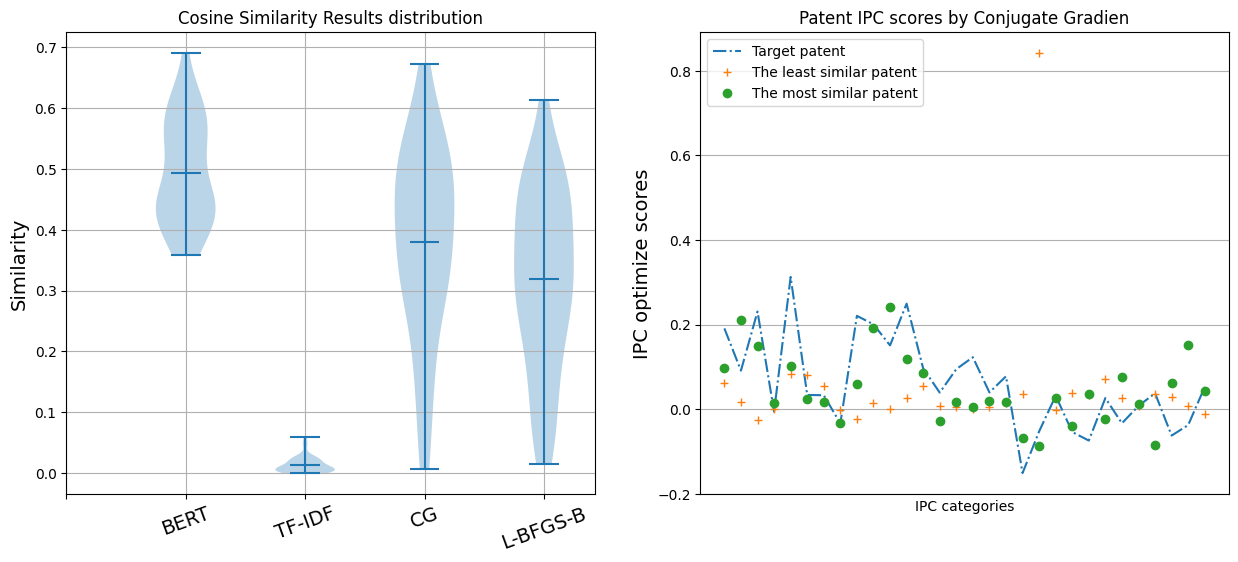

In [42]:
all_results = [results_BERT[1:], results_tf[1:], 
               results_CG[1:], results_LB[1:]]

result_x_ticks = ['','BERT','TF-IDF', 'CG','L-BFGS-B']


fig, axs = plt.subplots(1,2, figsize=(15, 6))
# plot violin plot
axs[0].violinplot(all_results,
                  showmeans=True,
                  showmedians=False)
axs[0].set_title('Cosine Similarity Results distribution')
axs[0].set_ylabel('Similarity', fontsize=14)
axs[0].set_xticks(range(len(all_results)+1))
axs[0].set_xticklabels(result_x_ticks, rotation=20, fontsize=14)
axs[0].grid()

axs[1].plot(sent_uncons_CG[0], '-.', label='Target patent')
axs[1].plot(sent_uncons_CG[result_sort_CG[-1]],'+', label='The least similar patent')
axs[1].plot(sent_uncons_CG[result_sort_CG[1]],'o', label='The most similar patent')
axs[1].set_title('Patent IPC scores by Conjugate Gradien')
axs[1].set_ylabel('IPC optimize scores', fontsize=14)
axs[1].set_xticks([]) 
axs[1].set_xlabel('IPC categories')
axs[1].grid()
axs[1].legend()
# plt.savefig('similarity_range_biomedical.jpg', dpi=700)